In [3]:
import joblib
import sys
from scipy import stats

sys.modules['sklearn.externals.joblib'] = joblib

In [4]:
import os
import argparse
from pathlib import Path

import numpy as np
import pandas as pd
from nilearn import input_data
from nilearn import plotting
import nilearn
import nibabel as nib

from nilearn import image as nimg

import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

/home/connectome/stellasybae/.conda/envs/stellasybae/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [5]:
file_atlas = 'atlas-harvardoxford_cort-maxprob-thr25.nii'
outer_dir = '/scratch/bigdata/ABCD/fmriprep/1.rs_fmri/1.rs_fmri_untar/'

In [6]:
sub_list = np.loadtxt('./rsfMRI_sub_list.txt',delimiter=',',dtype='str')

In [7]:
sub_list[0]

'sub-NDARINVGH70J8FC'

# 01 without mask

In [12]:
# npy로 바꾸는+cleaning 하는 코드
def cleaning(file_atlas, raw_img_input, confound_files, file_output):
    img_input = raw_img_input.slicer[:, :, :, 10:]
   
    confound_df = pd.read_csv(confound_files, delimiter='\t',
                              names = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z'])
    drop_confound_df = confound_df.iloc[11:, :]
    confounds_matrix = drop_confound_df.values
    
    clean_img = nimg.clean_img(img_input,confounds=confounds_matrix,detrend=True,standardize=True,
                           low_pass=0.04, high_pass=0.0009, t_r=0.8) #, mask_img=mask)

    #a = nib.Nifti1Image(clean_img, None) 
    
    nib.save(clean_img,str(file_output))

In [13]:
for i in range(10):#sub_list.shape[0]):
    # for input
    subject_string = sub_list[i]
    input_dir = outer_dir+subject_string+'/ses-baselineYear1Arm1/func/'
    img_input_raw = nib.load(input_dir+subject_string+'_ses-baselineYear1Arm1_task-rest_run-1_space-MNIPediatricAsym_cohort-4_res-2_desc-preproc_bold.nii.gz')
    file_output = './cleaned_image/cleaned_fmriprep_'+subject_string+'_HarvardOxford_timeseries_headmovecorrected.nii.gz'
    confound_files = input_dir+subject_string+'_ses-baselineYear1Arm1_task-rest_run-1_desc-confounds_timeseries.tsv'
    
    # code run
    cleaning(file_atlas,img_input_raw, confound_files, file_output) #head correction + filtering + TR

In [14]:
test=nib.load('./cleaned_image/cleaned_fmriprep_sub-NDARINVWDCENDZ9_HarvardOxford_timeseries_headmovecorrected.nii.gz')

In [17]:
test.shape

(99, 117, 95, 373)

In [41]:
99*117*95*373

410443605

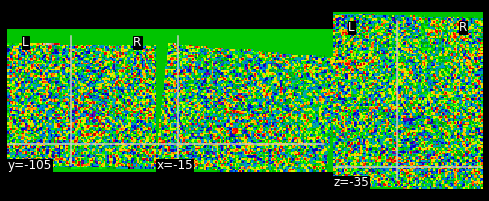

In [18]:
plotting.plot_epi(test.slicer[:, :, :, 370]) #random timepoint I don't know why this happens... Ich habe kiene Idee wenn 'epi'
# 마스크를 안 먹여서 그러는거야?? 마스크도 먹일까?? 

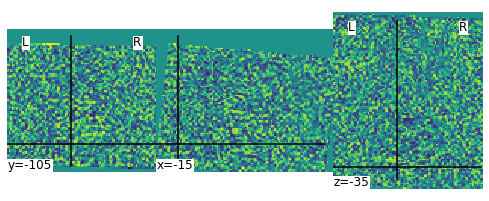

In [26]:
plotting.plot_img(test.slicer[:, :, :, 370]) #random timepoint

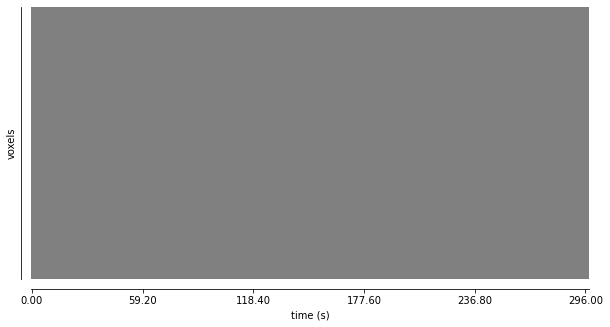

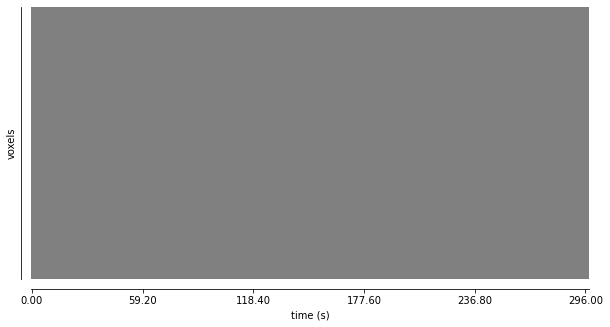

In [27]:
plotting.plot_carpet(test) #.slicer[:, :, :, 370]) #random timepoint

In [19]:
test_array=test.get_fdata()

In [20]:
z_sequence_nilearn = stats.zscore(test_array, axis=0)

In [21]:
ans=0
for i in range(99):
    for j in range(117):
        for k in range(95):
            for l in range(373):
                if z_sequence_nilearn[i][j][k][l] > 5 or z_sequence_nilearn[i][j][k][l] < -5:
                    ans+=1

In [22]:
ans
# 187564 when axis=0, nipype motion correction with mcflirt
# 33621 when axis=0, nilearn motion correction with clean image

33621

In [23]:
subject_string = 'sub-NDARINVWDCENDZ9'
input_dir = outer_dir+subject_string+'/ses-baselineYear1Arm1/func/'
confound_files = input_dir+subject_string+'_ses-baselineYear1Arm1_task-rest_run-1_desc-confounds_timeseries.tsv'
confound_df = pd.read_csv(confound_files, delimiter='\t')
confound_df_ = confound_df[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
motion = confound_df_.iloc[10:, :]

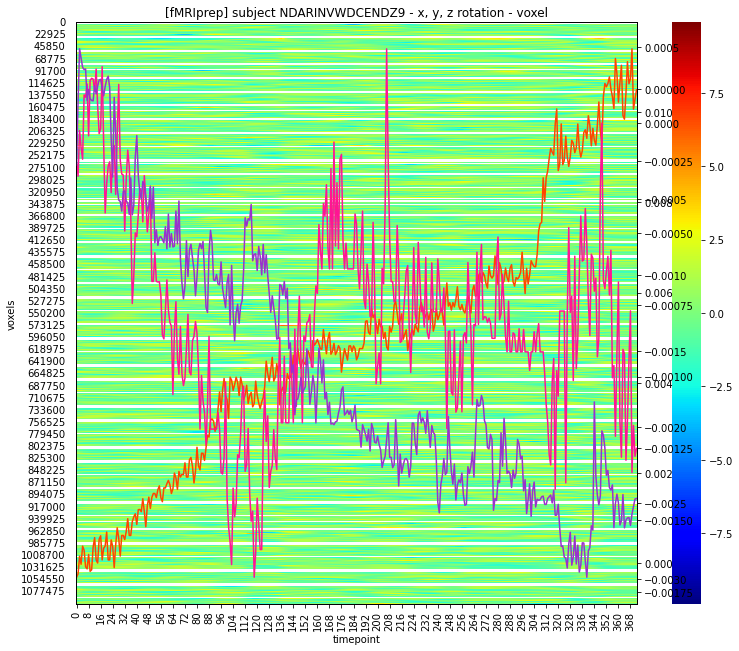

In [25]:
f, ax = plt.subplots(figsize=(11, 9))
plt.tick_params(bottom='on')

ax = sn.heatmap(z_sequence_nilearn.reshape(-1, 373), cmap='jet', cbar=True)
cbar_kws={"orientation": "horizontal", "pad":0.15}
ax.tick_params(axis='y', length=0, labelrotation=0, pad=10)
ax.set_ylabel('voxels')
ax.set_xlabel('timepoint')

ax2 = ax.twinx()
z_rotation = list(np.array(motion.iloc[:, 3:4]).reshape(-1,))
ax2.plot(z_rotation, color='orangered')
line1 = ax2.lines[0] # get the line
line1.set_xdata(line1.get_xdata()+ 0.5)
#ax2.set_ylabel('z rotation (radian)')

ax3 = ax.twinx()
x_rotation = list(np.array(motion.iloc[:, 4:5]).reshape(-1,))
ax3.plot(x_rotation, color='deeppink')
line2 = ax3.lines[0] # get the line
line2.set_xdata(line2.get_xdata()+ 0.5)
#ax3.set_ylabel('x rotation (radian)')

ax4 = ax.twinx()
y_rotation = list(np.array(motion.iloc[:, 5:6]).reshape(-1,))
ax4.plot(y_rotation, color='darkorchid')
line3 = ax4.lines[0] # get the line
line3.set_xdata(line3.get_xdata()+ 0.5)
#ax4.set_ylabel('y rotation (radian)')

ax.axis('tight')
ax2.axis('tight')
ax3.axis('tight')
ax4.axis('tight')

plt.tight_layout()

plt.title('[fMRIprep] subject NDARINVWDCENDZ9 - x, y, z rotation - voxel')
plt.show()

# 02 with mask

## 2-1 cleaning

### (1) cleaning base code

In [28]:
# cleaning 하는 코드
def cleaning(file_atlas, raw_img_input, mask, confound_files, file_output):
    img_input = raw_img_input.slicer[:, :, :, 10:]
   
    confound_df = pd.read_csv(confound_files, delimiter='\t',
                              names = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z'])
    drop_confound_df = confound_df.iloc[11:, :]
    confounds_matrix = drop_confound_df.values
    
    clean_img = nimg.clean_img(img_input,confounds=confounds_matrix,detrend=True,standardize=True,
                           low_pass=0.04, high_pass=0.0009, t_r=0.8, mask_img=mask)

    #a = nib.Nifti1Image(clean_img, None) 
    
    nib.save(clean_img,str(file_output))

### (2) execution

In [29]:
for i in range(10):#sub_list.shape[0]):
    # for input
    subject_string = sub_list[i]
    input_dir = outer_dir+subject_string+'/ses-baselineYear1Arm1/func/'
    
    # raw image
    img_input_raw = nib.load(input_dir+subject_string+'_ses-baselineYear1Arm1_task-rest_run-1_space-MNIPediatricAsym_cohort-4_res-2_desc-preproc_bold.nii.gz')
    
    # mask
    mask = nib.load(input_dir+subject_string+'_ses-baselineYear1Arm1_task-rest_run-1_space-MNIPediatricAsym_cohort-4_res-2_desc-brain_mask.nii.gz')

    
    # confound
    # for output
    file_output = './cleaned_image_with_mask/cleaned_image_'+subject_string+'.nii.gz' #이걸로 바꿨음 샘플 이름은 이거 아님
    confound_files = input_dir+subject_string+'_ses-baselineYear1Arm1_task-rest_run-1_desc-confounds_timeseries.tsv'
    
    # code run
    cleaning(file_atlas,img_input_raw, mask, confound_files, file_output) #head correction + filtering + TR

### (3) plotting cleaned+masked image

In [8]:
test=nib.load('./cleaned_image_with_mask/cleaned_fmriprep_sub-NDARINVWDCENDZ9_HarvardOxford_timeseries_headmovecorrected.nii.gz')

In [9]:
test.shape

(99, 117, 95, 373)

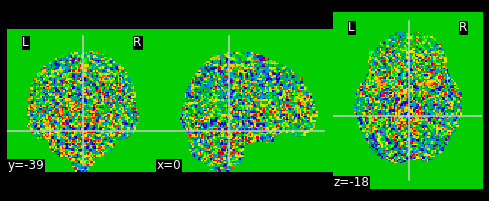

In [10]:
plotting.plot_epi(test.slicer[:, :, :, 370]) #random timepoint I don't know why this happens... Ich habe kiene Idee wenn 'epi'
#마스크 먹임

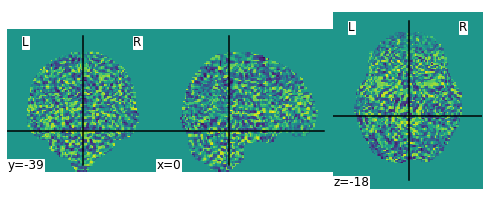

In [11]:
plotting.plot_img(test.slicer[:, :, :, 370]) #random timepoint

## 2-2 ROI extraction

### (1) extracting base code

In [33]:
# ROI extraction 코드
def extract_atlas_timeseries(img_input_cleaned, file_output):
    print(img_input_cleaned.shape)
    file_atlas = 'atlas-harvardoxford_cort-maxprob-thr25.nii'    
    masker = input_data.NiftiLabelsMasker(labels_img = file_atlas, verbose = 1, low_pass=0.04, high_pass=0.009, t_r = 0.8, standardize=True)
    
    masker.fit()
    
    masker.generate_report()
    ts = masker.transform(img_input_cleaned)
    
    np.save(str(file_output),ts)

### (2) execution

In [34]:
input_dir = './cleaned_image_with_mask/'
file_list=os.listdir(input_dir)

for i in range(10):#sub_list.shape[0]):    
    # raw image
    img_input_cleaned = nib.load(input_dir+file_list[i])
    
    # subject list
    subject_string = file_list[i].split('_')[2]
    
    # for output
    file_output = './cleaned_timeseries_with_mask/cleaned_timeseries_'+subject_string+'_HarvardOxford'
    
    # code run
    extract_atlas_timeseries(img_input_cleaned, file_output) #head correction + filtering + TR

(99, 117, 95, 373)
[NiftiLabelsMasker.fit] loading data from atlas-harvardoxford_cort-maxprob-thr25.nii


/home/connectome/stellasybae/.conda/envs/stellasybae/lib/python3.9/site-packages/nilearn/maskers/nifti_labels_masker.py:305: UserWarning: No image provided to fit in NiftiLabelsMasker. Plotting ROIs of label image on the MNI152Template for reporting.
  warnings.warn(msg)
/home/connectome/stellasybae/.conda/envs/stellasybae/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image('cleaned_image_with_mask/cleaned_fmriprep_sub-NDARINVHF0XT8CF_HarvardOxford_timeseries_headmovecorrected.nii.gz')
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(99, 117, 95, 370)
[NiftiLabelsMasker.fit] loading data from atlas-harvardoxford_cort-maxprob-thr25.nii


/home/connectome/stellasybae/.conda/envs/stellasybae/lib/python3.9/site-packages/nilearn/maskers/nifti_labels_masker.py:305: UserWarning: No image provided to fit in NiftiLabelsMasker. Plotting ROIs of label image on the MNI152Template for reporting.
  warnings.warn(msg)


[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image('cleaned_image_with_mask/cleaned_fmriprep_sub-NDARINVH9F934NE_HarvardOxford_timeseries_headmovecorrected.nii.gz')
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(99, 117, 95, 373)
[NiftiLabelsMasker.fit] loading data from atlas-harvardoxford_cort-maxprob-thr25.nii
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image('cleaned_image_with_mask/cleaned_fmriprep_sub-NDARINV73D1F1AM_HarvardOxford_timeseries_headmovecorrected.nii.gz')
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
(99, 117, 95, 373)
[NiftiLabelsMasker.fit] loading data from atlas-harvardoxford_cort-maxprob-thr25.nii
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image('cleaned_image_with_mask/cleaned_fmriprep_sub-NDARINVD1PL1RD3_HarvardOxfor

### (3) plotting in ROI scale

In [39]:
test=np.load('./cleaned_timeseries_with_mask/cleaned_timeseries_sub-NDARINV73D1F1AM_HarvardOxford.npy')

In [40]:
test.shape

(373, 48)

In [41]:
z_sequence = stats.zscore(test, axis=0)
ans=0
for i in range(373):
    for j in range(48):
        if z_sequence[i][j] > 5 or z_sequence[i][j] < -5:
            ans+=1

In [42]:
ans

0

### (4) plotting in voxel size

In [43]:
test=nib.load('./cleaned_image_with_mask/cleaned_fmriprep_sub-NDARINVWDCENDZ9_HarvardOxford_timeseries_headmovecorrected.nii.gz')

In [44]:
test_array=test.get_fdata()

In [45]:
z_sequence_nilearn = stats.zscore(test_array, axis=0)

In [ ]:
ans=0
for i in range(99):
    for j in range(117):
        for k in range(95):
            for l in range(373):
                if z_sequence_nilearn[i][j][k][l] > 5 or z_sequence_nilearn[i][j][k][l] < -5:
                    print(i,j,k,l)
                    ans+=1

In [38]:
ans #187564 when axis=0, nipype motion correction with mcflirt

167429

In [48]:
z_sequence_nilearn[17][40][38][184]

5.152716358336776

In [49]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 12

def plot_series(time, series, format="-", start=0, end=373, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [50]:
time = [i for i in range(373)]

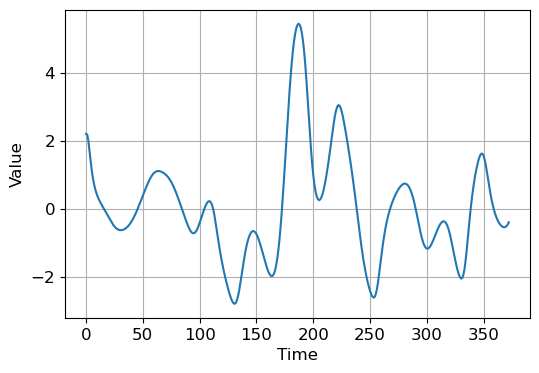

In [57]:
plot_series(time, list(z_sequence_nilearn[17][40][38]))
plt.show()

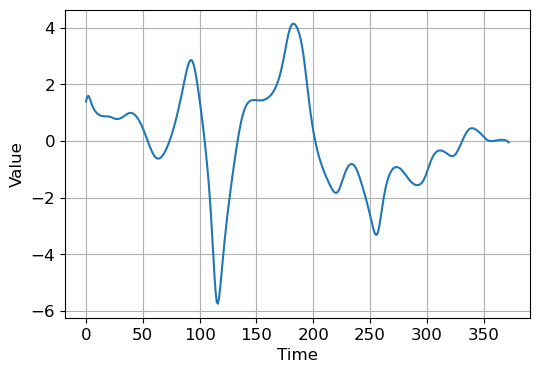

In [58]:
plot_series(time, list(z_sequence_nilearn[17][42][57]))
plt.show()

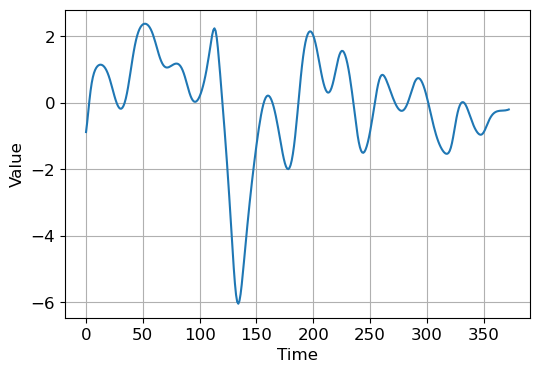

In [60]:
plot_series(time, list(z_sequence_nilearn[18][38][30]))
plt.show()

In [2]:
167429*100/410443605

0.04079220578914855

In [39]:
subject_string = 'sub-NDARINVWDCENDZ9'
input_dir = outer_dir+subject_string+'/ses-baselineYear1Arm1/func/'
confound_files = input_dir+subject_string+'_ses-baselineYear1Arm1_task-rest_run-1_desc-confounds_timeseries.tsv'
confound_df = pd.read_csv(confound_files, delimiter='\t')
confound_df_ = confound_df[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
motion = confound_df_.iloc[10:, :]

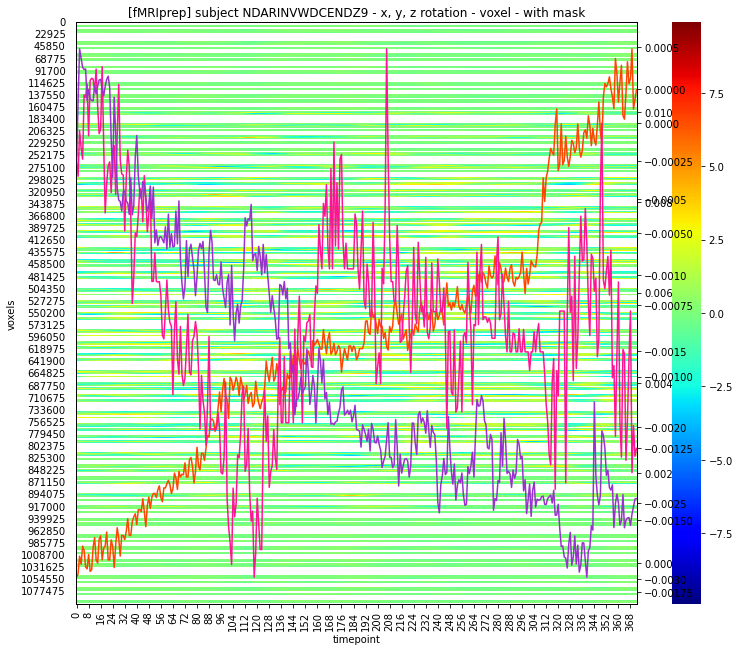

In [40]:
f, ax = plt.subplots(figsize=(11, 9))
plt.tick_params(bottom='on')

ax = sn.heatmap(z_sequence_nilearn.reshape(-1, 373), cmap='jet', cbar=True)
cbar_kws={"orientation": "horizontal", "pad":0.15}
ax.tick_params(axis='y', length=0, labelrotation=0, pad=10)
ax.set_ylabel('voxels')
ax.set_xlabel('timepoint')

ax2 = ax.twinx()
z_rotation = list(np.array(motion.iloc[:, 3:4]).reshape(-1,))
ax2.plot(z_rotation, color='orangered')
line1 = ax2.lines[0] # get the line
line1.set_xdata(line1.get_xdata()+ 0.5)
#ax2.set_ylabel('z rotation (radian)')

ax3 = ax.twinx()
x_rotation = list(np.array(motion.iloc[:, 4:5]).reshape(-1,))
ax3.plot(x_rotation, color='deeppink')
line2 = ax3.lines[0] # get the line
line2.set_xdata(line2.get_xdata()+ 0.5)
#ax3.set_ylabel('x rotation (radian)')

ax4 = ax.twinx()
y_rotation = list(np.array(motion.iloc[:, 5:6]).reshape(-1,))
ax4.plot(y_rotation, color='darkorchid')
line3 = ax4.lines[0] # get the line
line3.set_xdata(line3.get_xdata()+ 0.5)
#ax4.set_ylabel('y rotation (radian)')

ax.axis('tight')
ax2.axis('tight')
ax3.axis('tight')
ax4.axis('tight')

plt.tight_layout()

plt.title('[fMRIprep] subject NDARINVWDCENDZ9 - x, y, z rotation - voxel - with mask')
plt.show()